<a href="https://colab.research.google.com/github/guillermodulcey/TesisCinvestav/blob/main/Implicito/Modelo_implicito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
SIZE = 3000

In [ ]:
class DatasetAlignment():
  def __init__(self, size=3000, val_size=2000):
    text_dataset = tf.keras.preprocessing.text_dataset_from_directory(
      '/content/drive/MyDrive/Datasets/TranscriptionsB',
      labels="inferred",
      label_mode="int",
      class_names=None,
      batch_size=2000,
      max_length=None,
      shuffle=True,
      seed=123,
      validation_split=.2,
      subset='training',
      follow_links=False,
    )

    text_validation = tf.keras.preprocessing.text_dataset_from_directory(
      '/content/drive/MyDrive/Datasets/TranscriptionsB',
      labels="inferred",
      label_mode="int",
      class_names=None,
      batch_size=2000,
      max_length=None,
      shuffle=True,
      seed=123,
      validation_split=.2,
      subset='validation',
      follow_links=False,
    )

    (colorectal_dataset, colorectal_validation), colorectal_info = tfds.load('colorectal_histology', 
                                                      split=[f'train[:{size}]', f'train[{size}:]'], 
                                                      shuffle_files=False, 
                                                      with_info=True, 
                                                      as_supervised=True)

    self.cats_dogs = colorectal_dataset.take(size)
    self.reviews = text_dataset.take(size)

    self.validation_cats_dogs = colorectal_validation.take(val_size)
    self.validation_reviews = text_validation.take(val_size)

  def train_text(self, max_words=10000):
    for texts, t_labels in self.reviews.take(1):  # only take first batch of dataset
      numpy_text = texts.numpy()
      numpy_t_labels = t_labels.numpy()

    train = pd.DataFrame()
    train['text'] = pd.Series(numpy_text)
    train['label'] = pd.Series(numpy_t_labels)

    train_labels = train['label']
    train_text = train['text']

    train_text = train_text.apply(lambda x: x.decode('utf-8'))

    self.tokenizer = Tokenizer(max_words, oov_token='<OOV>')

    self.tokenizer.fit_on_texts(train_text.to_list())
    self.total_words = len(self.tokenizer.word_index)+1

    train_sequences = self.tokenizer.texts_to_sequences(train_text.to_list())
    train_padded = pad_sequences(train_sequences)

    train_labels = np.array(train_labels.to_list())

    self.max_sequence_length = train_padded.shape[1]

    self.reviews = tf.data.Dataset.from_tensor_slices((train_padded, train_labels))

    ## Validation
    for texts, t_labels in self.validation_reviews.take(1):  # only take first batch of dataset
      validation_text = texts.numpy()
      validation_labels = t_labels.numpy()

    validation = pd.DataFrame()
    validation['text'] = pd.Series(validation_text)
    validation['label'] = pd.Series(validation_labels)

    validation_labels = validation['label']

    validation_text = validation['text']
    validation_text = validation_text.apply(lambda x: x.decode('utf-8'))

    validation_sequences = self.tokenizer.texts_to_sequences(validation_text.to_list())
    validation_padded = pad_sequences(validation_sequences, maxlen=self.max_sequence_length)

    validation_labels = np.array(validation_labels.to_list())

    self.validation_reviews = tf.data.Dataset.from_tensor_slices((validation_padded, validation_labels))

  def align(self):
    one_i = self.cats_dogs.filter(lambda x,y: y == 0)
    two_i = self.cats_dogs.filter(lambda x,y: y == 1)
    
    one_t = self.reviews.filter(lambda x,y: y == 0)
    two_t = self.reviews.filter(lambda x,y: y == 1)
    
    one_z = tf.data.Dataset.zip((one_i, one_t))
    two_z = tf.data.Dataset.zip((two_i, two_t))

    merged = one_z.concatenate(two_z)

    self.cats_dogs = merged.map(lambda x, y: x)
    self.reviews = merged.map(lambda x, y: y)

    return self.cats_dogs, self.reviews

  def validation(self, size=10000):
    one_i = self.validation_cats_dogs.filter(lambda x,y: y == 0)
    two_i = self.validation_cats_dogs.filter(lambda x,y: y == 1)

    one_t = self.validation_reviews.filter(lambda x,y: y == 0)
    two_t = self.validation_reviews.filter(lambda x,y: y == 1)

    one_z = tf.data.Dataset.zip((one_i, one_t))
    two_z = tf.data.Dataset.zip((two_i, two_t))

    merged = one_z.concatenate(two_z)

    self.validation_cats_dogs = merged.map(lambda x, y: x)
    self.validation_reviews = merged.map(lambda x, y: y)

    return self.validation_cats_dogs, self.validation_reviews


In [ ]:
da = DatasetAlignment()

Found 1619 files belonging to 2 classes.
Using 1296 files for training.
Found 1619 files belonging to 2 classes.
Using 323 files for validation.


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incomplete6GDYMW/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [ ]:
da.train_text()
total_words = da.total_words
max_sequence_length = da.max_sequence_length

cats_dogs, reviews = da.align()

In [ ]:
input_cats_dogs = cats_dogs

input_reviews = reviews

In [ ]:
URL = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
feature_extractor = hub.KerasLayer(URL, input_shape=[], dtype=tf.string)

weights = feature_extractor.get_weights()
weights = np.squeeze(weights)

embedding_matrix = np.zeros((total_words,50))

embedding_matrix[1:] = weights[:total_words-1]

In [ ]:
resize_function = lambda x, y: (tf.image.resize(x, (299, 299))/255.0, y)

input_cats_dogs = input_cats_dogs.map(resize_function).batch(32).prefetch(1)

In [ ]:
IMAGE_RES = 299
URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3), name="imagenet")
feature_extractor.trainable = False

image_model = tf.keras.Sequential([
            feature_extractor
])

cats_dogs_encoded = image_model.predict(input_cats_dogs, verbose=1)

25/25 [==============================] - 39s 341ms/step


In [ ]:
cats_dogs_encoded.shape

(750, 2048)

In [ ]:
tf.keras.backend.clear_session()

###### Image
input_image = tf.keras.Input(shape=(2048), name="input_image")
###############################################

###### Text
input_text = tf.keras.Input(shape=(max_sequence_length), name="input_text")

x = tf.keras.layers.Embedding(total_words, 50, input_length=max_sequence_length, weights=[embedding_matrix], trainable=True)(input_text)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(10, return_sequences=True))(x)
x = tf.keras.layers.GRU(10)(x)
text_model = tf.keras.layers.Dense(16, 'relu')(x)
###############################################


###### Concatenate
# c = tf.keras.layers.concatenate([input_image, text_model])

output_image = tf.keras.layers.Dense(1, 'sigmoid', name='output_image')(input_image)
output_text = tf.keras.layers.Dense(1, 'sigmoid', name='output_text')(text_model)
###############################################
model = tf.keras.Model(inputs=[input_image, input_text], outputs=[output_image, output_text])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 69)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 69, 50)       208300      input_text[0][0]                 
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 69, 20)       3720        embedding[0][0]                  
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 10)           960         bidirectional[0][0]              
______________________________________________________________________________________________

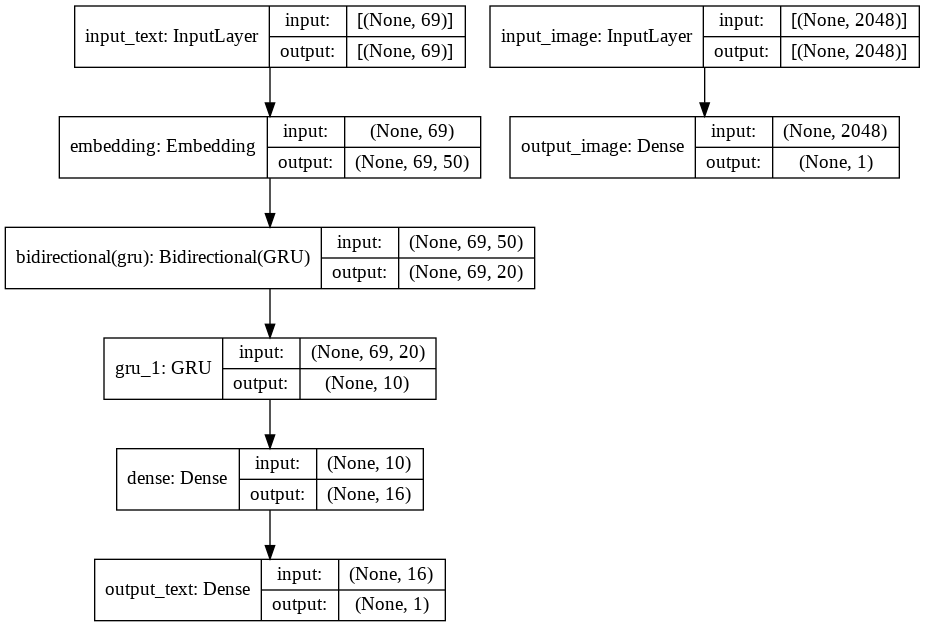

In [ ]:
tf.keras.utils.plot_model(model, "multimodal.png", show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[
        tf.keras.losses.BinaryCrossentropy(),
        tf.keras.losses.BinaryCrossentropy(),
    ],
    loss_weights=[1, 1],
    metrics=['accuracy']
)

In [ ]:
y2 = np.concatenate([yc.numpy() for _ , yc in input_cats_dogs], axis=0)

y2.shape

(750,)

In [ ]:
for text, labels2 in input_reviews.batch(SIZE).take(1):  # only take first element of dataset
    numpy_text = text.numpy()
    numpy_labels2 = labels2.numpy()

numpy_labels2.shape

(750,)

In [ ]:
class Stopper(tf.keras.callbacks.Callback):
  def __init__(self, metric, value):
    super().__init__()
    self.metric = metric
    self.value = value

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get(self.metric)>self.value):
      print(f"\nReached {self.value} {self.metric} or above")
      self.model.stop_training = True

callbacks = Stopper('output_text_accuracy', 0.9)

In [ ]:
model.fit(
    {"input_image": cats_dogs_encoded, "input_text": numpy_text},
    {"output_image": y2, "output_text": numpy_labels2},
    epochs=10,
    # callbacks=[callbacks]
)

Epoch 1/10
24/24 [==============================] - 7s 46ms/step - loss: 1.0560 - output_image_loss: 0.3653 - output_text_loss: 0.6906 - output_image_accuracy: 0.9013 - output_text_accuracy: 0.5347
Epoch 2/10
24/24 [==============================] - 1s 46ms/step - loss: 0.8352 - output_image_loss: 0.1650 - output_text_loss: 0.6701 - output_image_accuracy: 0.9720 - output_text_accuracy: 0.6707
Epoch 3/10
24/24 [==============================] - 1s 46ms/step - loss: 0.7118 - output_image_loss: 0.1129 - output_text_loss: 0.5990 - output_image_accuracy: 0.9813 - output_text_accuracy: 0.7907
Epoch 4/10
24/24 [==============================] - 1s 45ms/step - loss: 0.4519 - output_image_loss: 0.0906 - output_text_loss: 0.3613 - output_image_accuracy: 0.9840 - output_text_accuracy: 0.8853
Epoch 5/10
24/24 [==============================] - 1s 45ms/step - loss: 0.2488 - output_image_loss: 0.0769 - output_text_loss: 0.1719 - output_image_accuracy: 0.9893 - output_text_accuracy: 0.9360
Epoch 6/10

In [ ]:
da.validation()

(<MapDataset shapes: ((150, 150, 3), ()), types: (tf.uint8, tf.int64)>,
 <MapDataset shapes: ((69,), ()), types: (tf.int32, tf.int64)>)

In [ ]:
validation_cats_dogs = da.validation_cats_dogs.map(resize_function).batch(32).prefetch(1)

In [ ]:
validation_cats_dogs_encoded = image_model.predict(validation_cats_dogs, verbose=1)

12/12 [==============================] - 5s 385ms/step


In [ ]:
y3 = np.concatenate([yc.numpy() for _ , yc in validation_cats_dogs], axis=0)

y3.shape

(323,)

In [ ]:
validation_reviews = da.validation_reviews.batch(SIZE)

In [ ]:
for text, labels2 in validation_reviews.take(1):  # only take first element of dataset
    validation_numpy_text = text.numpy()
    validation_numpy_labels = labels2.numpy()

validation_numpy_labels.shape

(323,)

In [ ]:
model.evaluate({"input_image": validation_cats_dogs_encoded, "input_text": validation_numpy_text},
    {"output_image": y3, "output_text": validation_numpy_labels})

11/11 [==============================] - 1s 20ms/step - loss: 0.6877 - output_image_loss: 0.0481 - output_text_loss: 0.6396 - output_image_accuracy: 0.9938 - output_text_accuracy: 0.8111


[0.6876586079597473,
 0.04809178411960602,
 0.6395667791366577,
 0.9938080310821533,
 0.8111454844474792]

In [ ]:
model_result = model.predict({"input_image": validation_cats_dogs_encoded, "input_text": validation_numpy_text})

In [ ]:
y_pred_image = [y_t.item() for y_t in model_result[0]]
y_pred_text = [y_t.item() for y_t in model_result[1]]

# Método mayor seguridad

In [ ]:
y_pred_image_b = [0 if y_t < 0.5 else 1 for y_t in model_result[0]]
y_pred_text_b = [0 if y_t < 0.5 else 1 for y_t in model_result[1]]

In [ ]:
final_result = []
for i, value in enumerate(y_pred_image):
  if y_pred_text[i] != value:
    cert_a = (0.5 - y_pred_image[i])**2
    cert_b = (0.5 - y_pred_text[i])**2
    if cert_a > cert_b:
      final_result.append(value)
    else:
      final_result.append(y_pred_text[i])
  else:
    final_result.append(value)

In [ ]:
y_vali = [0 if y_t < 0.5 else 1 for y_t in final_result]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(validation_numpy_labels, y_vali))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       105
           1       0.97      0.94      0.96       218

    accuracy                           0.94       323
   macro avg       0.93      0.94      0.93       323
weighted avg       0.94      0.94      0.94       323



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(validation_numpy_labels, y_vali)

array([[ 98,   7],
       [ 12, 206]])